In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
import dgl
from dgl.data import DGLDataset
import torch
import os

edges_fMRI = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
# edges_dMRI_fused = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_fused.csv')
# edges_dMRI_ses1 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses1.csv')
# edges_dMRI_ses2 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses2.csv')
properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')

edges_fMRI.head()

properties.head()

class BNU1Dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        edges = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
        properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')
        self.graphs = []
        self.labels = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['src'].to_numpy()
            dst = edges_of_id['dst'].to_numpy()
            weight = edges_of_id['weight'].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            weight = torch.FloatTensor(weight)
            g.edata['weight'] = weight
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = BNU1Dataset()
graph, label = dataset[0]
print(graph, label)

Using backend: pytorch


Graph(num_nodes=70, num_edges=24,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)}) tensor(1)


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import re
%matplotlib inline

graph_idx = 0
Graphs = []
pos_idx = []
neg_idx = []
f = csv.reader(open('./BNU1_fMRI/BNU1_phenotypic_data.csv','r')) 
for j, row in enumerate(f):
    if j != 0 and j % 2 ==1:
        label = row[3]
        filter(str.isdigit, label)
        if int(label)-1 == 1:
            pos_idx.append(graph_idx)
        else:
            neg_idx.append(graph_idx)
        graph_idx += 1

edge_list_2_downsampling = []
edge_list_2_downsampling_ = []
edge_list_2_property = [] 
pos_adj_list = []
neg_adj_list = []
adj_list = []
labels = []
length = 25920 - 25864 + 1
for i in range(length):
    G00 = nx.read_gpickle("./BNU1_fMRI/sub-00%s_ses-1_bold_desikan_res-2x2x2_measure-correlation.gpickle"%(int(i+25864)))
    edge_list_2 = []
    edge = G00.adj
    for src in edge:
        for dst in edge[src]:
            edge_list_2.append([src, dst, edge[src][dst]['weight']])
    for edge in edge_list_2:
        if edge[0] == edge[1]:
            continue
        elif edge[2] <= 0.8:
            edge_list_2_downsampling.append([edge[0]-1, edge[1]-1, 0])
        else:
            edge_list_2_downsampling.append([edge[0]-1, edge[1]-1, edge[2]])
            edge_list_2_downsampling_.append([i, edge[0]-1, edge[1]-1])
    G2 = nx.Graph()
    G2.add_weighted_edges_from(edge_list_2_downsampling)
    G2_ = nx.Graph()
    G2_.add_weighted_edges_from(edge_list_2_downsampling_)
    Graphs.append(G2_)
    A2 = nx.to_numpy_array(G2)
    adj_list.append(A2)
    if i in pos_idx:
        labels.append('male')
        pos_adj_list.append(A2)
#         np.stack((pos_adj_list, A2),axis=0)
    else:
        labels.append('female')
        neg_adj_list.append(A2)

In [39]:
import networkx as nx
from joblib import Parallel, delayed
import pickle
import os, sys
import time
import numpy as np

def make_direct(direct):
    # has side effect
    import os
    if not os.path.exists(direct):
            os.makedirs(direct)

def load_graph(graph, debug='off', single_graph_flag=True):
    # exptect label to be numpy.ndarry of shape (n,). However protein_data is different so have to handle it differently
    assert type(graph) == str
    print('Start Loading from dataset')
    file = os.path.join(graph + ".graph")
    # if not os.path.isfile(file): file = '/home/cai.507/Documents/DeepLearning/deep-persistence/dataset/datasets/' + graph + '.graph'
    f = open(file, 'rb')
    data = pickle.load(f, encoding='bytes')
#     print(data)
    graphs, labels = data[b'graph'], data[b'labels']
    return graphs, labels

    if debug == 'on':
        print(graph),
        print(type(labels), )
        print(np.shape(labels))
    print('Finish Loading graphs')
    outputFile = directory + '\graph+label'
    fw = open(outputFile, 'wb')
    dataset = (graphs, labels)
    pickle.dump(dataset, fw)
    fw.close()
    print('Finish Saving data for future use')
    return graphs, labels

def convert2nx(graph, i, print_flag='False'):
    # graph: python dict
    keys = graph.keys()
    try:
        assert keys == range(len(graph.keys()))
    except AssertionError:
        # print('%s graph has non consecutive keys'%i)
        # print('Missing nodes are the follwing:')
        for i in range(max(graph.keys())):
            if i not in graph.keys(): 
                print(i)

    # add nodes
    gi = nx.Graph()
    for i in keys: gi.add_node(i) # change from 1 to i.
    assert len(gi) == len(keys)

    # add edges
    for i in keys:
        for j in graph[i][b'neighbors']:
            if j > i:
                gi.add_edge(i, j)
    for i in keys:
        # print graph[i]['label']
        if graph[i][b'label']=='':
            print(gi)
            gi.nodes[i]['label'] = 1
            # continue
        try:
            gi.nodes[i]['label'] = graph[i][b'label'][0]
        except TypeError: # modifications for reddit_binary
            gi.nodes[i]['label'] = graph[i][b'label']
        except IndexError:
            gi.nodes[i]['label'] = 0 # modification for imdb_binary
    assert len(gi.nodes) == len(graph.keys())
    gi.remove_edges_from(nx.selfloop_edges(gi))
    if print_flag=='True': print('graph: %s, n_nodes: %s, n_edges: %s' %(i, len(gi), len(gi.edges)) )
    return gi

def attribute_mean(g, i, key='deg', cutoff=1, iteration=0):
    # g = graphs_[i][0]
    # g = graphs_[0][0]
    # attribute_mean(g, 0, iteration=1)
    for itr in [iteration]:
        assert key in g.nodes[i].keys()
        # nodes_b = nx.single_source_shortest_path_length(g,i,cutoff=cutoff).keys()
        # nodes_a = nx.single_source_shortest_path_length(g,i,cutoff=cutoff-1).keys()
        # nodes = [k for k in nodes_b if k not in nodes_a]
        nodes = g[i].keys()

        if iteration == 0:
            nbrs_deg = [g.nodes[j][key] for j in nodes]
        else:
            key_ = str(cutoff) + '_' + str(itr-1) + '_' + key +  '_' + 'mean'
            nbrs_deg = [g.nodes[j][key_] for j in nodes]
            g.nodes[i][ str(cutoff) + '_' + str(itr) + '_' + key] = np.mean(nbrs_deg)
            return

        oldkey = key
        key = str(cutoff) + '_' + str(itr) + '_' + oldkey
        key_mean = key + '_mean'; key_min = key + '_min'; key_max = key + '_max'; key_std = key + '_std'
        key_sum = key + '_sum'

        if len(nbrs_deg) == 0:
            g.nodes[i][key_mean] = 0
            g.nodes[i][key_min] = 0
            g.nodes[i][key_max] = 0
            g.nodes[i][key_std] = 0
            g.nodes[i][key_sum] = 0
        else:
            # assert np.max(nbrs_deg) < 1.1
            g.nodes[i][key_mean] = np.mean(nbrs_deg)
            g.nodes[i][key_min] = np.min(nbrs_deg)
            g.nodes[i][key_max] = np.max(nbrs_deg)
            g.nodes[i][key_std] = np.std(nbrs_deg)
            g.nodes[i][key_sum] = np.sum(nbrs_deg)

def function_basis(g, allowed, norm_flag = 'no'):
    # input: g
    # output: g with ricci, deg, hop, cc, fiedler computed
    # allowed = ['ricci', 'deg', 'hop', 'cc', 'fiedler']
    # to save recomputation. Look at the existing feature at first and then simply compute the new one.

    if len(g)<3: return
    assert nx.is_connected(g)

    def norm(g, key, flag=norm_flag):
        if flag=='no':
            return 1
        elif flag == 'yes':
            return np.max(np.abs(nx.get_node_attributes(g, key).values())) + 1e-6

    if 'deg' in allowed:
        deg_dict = dict(nx.degree(g))
        for n in g.nodes():
            g.nodes[n]['deg'] = deg_dict[n]
            # g_ricci.node[n]['deg'] = np.log(deg_dict[n]+1)

        deg_norm = norm(g, 'deg', norm_flag)
        for n in g.nodes():
            g.nodes[n]['deg'] /= np.float(deg_norm)
    if 'deg' in allowed:
        for n in g.nodes():
            attribute_mean(g, n, key='deg', cutoff=1, iteration=0)
        if norm_flag == 'yes':
            # better normalization
            for attr in [ '1_0_deg_sum']: # used to include 1_0_deg_std/ deleted now:
                norm_ = norm(g, attr, norm_flag)
                for n in g.nodes():
                    g.nodes[n][attr] /= float(norm_)
    return g

def get_subgraphs(g, threshold=1):
    assert str(type(g)) == "<class 'networkx.classes.graph.Graph'>"
    subgraphs = [g.subgraph(c).copy() for c in sorted(nx.connected_components(g), key=len, reverse=True)]
    subgraphs = [c for c in subgraphs if len(c) > threshold]
    return subgraphs

def new_norm(graphs_, bl_feat):
    """Normalize graph function uniformly"""
    newnorm = dict(zip(bl_feat, [0] * 5))
    for attr in bl_feat:
        for gs in graphs_:
            for g in gs:
                tmp = max(nx.get_node_attributes(g, attr).values())
                if tmp > newnorm[attr]:
                    newnorm[attr] = tmp

    for gs in graphs_:
        for g in gs:
            for n in g.nodes():
                for attr in bl_feat:
#                     print(g.nodes[n][attr])
                    g.nodes[n][attr] /= float(newnorm[attr])
#                     print(g.nodes[n][attr])
# #                     a
                    assert g.nodes[n][attr] <= 1
    return graphs_

def save_graphs_(graphs_, dataset='BNU1_fMRI', norm_flag='yes'):
    t0 = time.time()
    direct = os.path.join('./degree/', dataset, 'norm_flag_' + str(norm_flag) + '/')
    if not os.path.exists(direct): make_direct(direct)
    with open(direct + 'graphs', 'wb') as f:
        pickle.dump(graphs_, f)
    print('Saved graphs. Takes %s'%(time.time() - t0))

import numpy as np
import time

def functionongraph(graphs_, i, key='deg', edge_flag=False):
    # for graphs_[i], get the key-val distribution

    components = len(graphs_[i]); lis = []
    for j in range(components):
        g = graphs_[i][j]
        try:
            assert (str(type(g)) ==  "<class 'networkx.classes.graphviews.SubGraph'>") or (str(type(g))) == "<class 'networkx.classes.graph.Graph'>"
        except AssertionError:
            if g is None:
                print('wired case: g is None')
                return [0]
            else:
                print('Unconsidered Cases in function on graph')

        if edge_flag==False:
            tmp = [g.nodes[k][key] for k in g.nodes]
        lis += tmp
    return lis

def hisgram_single_feature(graphs_, n_bin, key='deg', his_norm_flag='yes', edge_flag=False, lowerbound=-1, upperbound=1, cdf_flag=False, uniform_flag = True):
    import numpy as np
    n = len(graphs_)
    feature_vec = np.zeros((n, n_bin))
    for i in range(n):
        lis = functionongraph(graphs_, i, key, edge_flag=edge_flag)
        if lis == []:
            feature_vec[i] = 0
        feature_vec[i] = hisgram(lis, n_bin, his_norm_flag=his_norm_flag,
                                 lowerbound=lowerbound, upperbound=upperbound,
                                 cdf_flag=cdf_flag, uniform_flag=uniform_flag)
    return feature_vec

def hisgram(lis, n_bin=100, his_norm_flag='yes', lowerbound=-1, upperbound=1, cdf_flag=False, uniform_flag=True):
    if lis == []:
        print ('lis is empty')
        return [0]*n_bin
    # normalize lis
    # needs to be more rigirous
    # TODO: test if it helps to normalize lis
    if his_norm_flag == 'yes':
        try:
            assert max(lis) < 1.1 # * 100000 # delelte 100 later
        except AssertionError:
            print ('The max of list is %s' %max(lis)),
        assert min(lis) > -1.1
        max_ = max(lis)
        # if max_ !=0:
        #     lis = [i/float(max_) for i in lis]

    if not uniform_flag:
        assert lowerbound + 1e-3 > 0
        n_bin_ = np.logspace(np.log(lowerbound + 1e-3), np.log(upperbound),n_bin+1, base = np.e)
    else:
        n_bin_ = n_bin

    if cdf_flag == True:
        from statsmodels.distributions.empirical_distribution import ECDF
        ecdf = ECDF(lis)
        if uniform_flag:
            return ecdf([i / np.float(n_bin) for i in range(0, n_bin)])
        else:
            return ecdf([i / np.float(n_bin) for i in range(0, n_bin)])
    result = np.histogram(lis, bins=n_bin_, range=(lowerbound,upperbound))
    return result[0]

def remove_zero_col(data, cor_flag=False):
    # data = np.zeros((2,10))
    # data[1,3] = data[1,5] = data[1,7] = 1
    n_col = np.shape(data)[1]

    del_col_idx = np.where(~data.any(axis=0))[0]
    remain_col_idx = set(range(n_col)) - set(del_col_idx)
    correspondence_dict = dict(zip(range(len(remain_col_idx)), remain_col_idx))
    inverse_correspondence_dict = dict(zip(remain_col_idx, range(len(remain_col_idx))))

    X = np.delete(data, np.where(~data.any(axis=0))[0], axis=1)
    print('the shape after removing zero columns is ', np.shape(X))
    if cor_flag == True:
        return (X, correspondence_dict, inverse_correspondence_dict)
    else:
        return X

def merge_features(graph, graphs_, allowed, n_bin=30, his_norm_flag='yes', edge_flag=False, cdf_flag=False, uniform_flag = True):
    print('Number of bins are %s'%n_bin)
    n = len(graphs_)
    X = np.zeros((n, 1))
    for key in allowed:
        # print(key)
        if (key=='label') :
            if graph == 'dd_test':
                nbin = 90
            else:
                nbin = 40
            tmp = hisgram_single_feature(graphs_, nbin, 'label', his_norm_flag=his_norm_flag, edge_flag=edge_flag, lowerbound=0, upperbound=1, cdf_flag=cdf_flag, uniform_flag=uniform_flag)

        elif key == 'ricciCurvature': # use default bound for ricci curvature
            tmp = hisgram_single_feature(graphs_, n_bin, key, his_norm_flag=his_norm_flag, edge_flag=edge_flag, cdf_flag=cdf_flag, uniform_flag=uniform_flag)
        else:
            tmp = hisgram_single_feature(graphs_, n_bin, key, his_norm_flag=his_norm_flag, edge_flag=edge_flag, cdf_flag=cdf_flag, uniform_flag=uniform_flag, lowerbound=0)
        X = np.append(X, tmp, axis=1)
    return remove_zero_col(X[:,1:])

import argparse
import networkx as nx
import numpy as np
import pickle
import sys, os
import time

dataset = 'BNU1_fMRI'
n_bin = 50
nonlinear_flag = False
uniform_flag = True

bl_feat = ['1_0_deg_min', '1_0_deg_max', '1_0_deg_mean', '1_0_deg_std', 'deg']

cdf_flag = True # cdf versus pdf. True for most dataset.
norm_flag = 'no'
his_norm_flag = 'yes'

# graphs, labels = load_graph(dataset)
n = len(Graphs)
graphs_ = []
# direct = os.path.join(dataset, 'norm_flag_' + str(norm_flag), '')

# try:
#     with open(direct + 'graphs_', 'rb') as f:
#         t0 = time.time()
#         graphs_ = pickle.load(f)
#         print('Finish loading existing graphs. Takes %s'%(time.time() - t0))
# except IOError:
for i in range(n):
    if i % 50 ==0: print('#'),
#     gi = convert2nx(graphs[i], i)
#     print(graphs[i])
#     a
#     print(type(Graphs[i]))
    subgraphs = get_subgraphs(Graphs[i])
    gi_s = [function_basis(gi, ['deg'], norm_flag=norm_flag) for gi in subgraphs]
    gi_s = [g for g in gi_s if g != None]
    graphs_.append(gi_s)
if norm_flag == 'no': graphs_ = new_norm(graphs_, bl_feat)
save_graphs_(graphs_, dataset=dataset, norm_flag=norm_flag)

x_original = merge_features(dataset, graphs_, bl_feat, n_bin, his_norm_flag=his_norm_flag, cdf_flag=cdf_flag, uniform_flag=uniform_flag)
if norm_flag=='yes':
    x_degree = normalize(x_original, axis = 1)
else:
    x_degree = x_original

#
#
Saved graphs. Takes 0.13866186141967773
Number of bins are 50
the shape after removing zero columns is  (57, 242)


In [5]:
# Embed mice graphs
# Single graph embedding
from graspologic.embed import node2vec_embed, AdjacencySpectralEmbed, LaplacianSpectralEmbed
# Multiple graph embedding
from graspologic.embed import OmnibusEmbed, MultipleASE, mug2vec
from graspologic.plot import pairplot

# Jointly embed graphs using omnibus embedding
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(adj_list)
print(omni_embedding.shape)

C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\graspologic\embed\omni.py:258: UserWarning: Input graphs are not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.multigraph_lcc_union``.
  warnings.warn(msg, UserWarning)


(57, 70, 7)


PolynomialFeatures(degree=6)


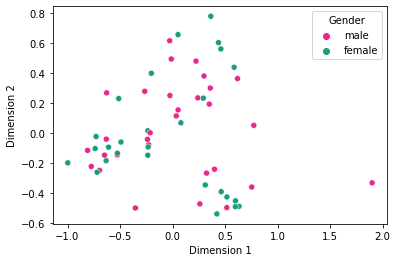

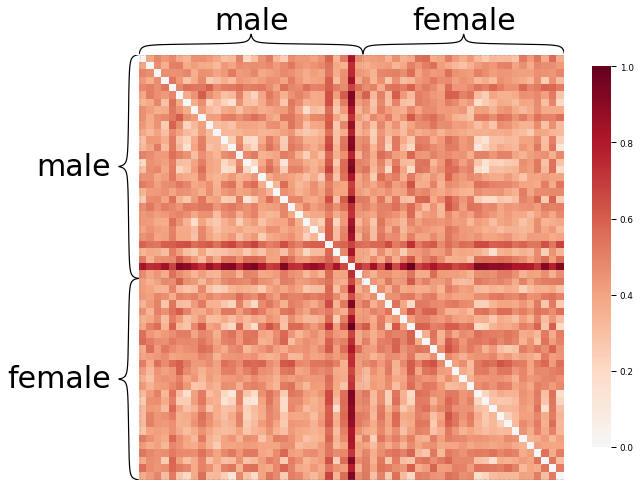

In [6]:
from graspologic.embed import ClassicalMDS
from graspologic.plot import heatmap
from sklearn.preprocessing import PolynomialFeatures

# Further reduce embedding dimensionality using cMDS
cmds = ClassicalMDS(2)
cmds_embedding_ = cmds.fit_transform(omni_embedding)
cmds_embedding = pd.DataFrame(cmds_embedding_, columns=["Dimension 1", "Dimension 2"])
cmds_embedding["Gender"] = labels
degree_nodal_covariates = PolynomialFeatures(degree=6)
print(degree_nodal_covariates)

# Embedding visualization
sns.scatterplot(
    x="Dimension 1",
    y="Dimension 2",
    hue="Gender",
    data=cmds_embedding,
    palette=["#e7298a", "#1b9e77"],
)
plt.show()

# Find the dissimilarity between subjects' connectomes using the cMDS embedding
dis = cmds.dissimilarity_matrix_
scaled_dissimilarity = dis / np.max(dis)

heatmap(scaled_dissimilarity,
        context="paper",
        inner_hier_labels=labels,)
plt.show()

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer

X = cmds_embedding_.reshape(omni_embedding.shape[0], -1)
one_hot = LabelBinarizer()
labels = np.array(labels)
y = one_hot.fit_transform(labels)

def plot_dataset(X, y, axes):
    plt.plot( X[:,0][y==0], X[:,1][y==0], "bs" )
    plt.plot( X[:,0][y==1], X[:,1][y==1], "g^" )
    plt.axis( axes )
    plt.grid( True, which="both" )
    plt.xlabel(r"$x_l$")
    plt.ylabel(r"$x_2$")

def plot_predict(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid( x0s, x1s )
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict( X )
    y_decision = clf.decision_function( X )
    y_pred_ = np.array(y_pred).reshape[-1, 1]
    plt.contour( x0, x1, y_pred_, cmap=plt.cm.winter, alpha=0.5 )
    plt.contour( x0, x1, y_decision, cmap=plt.cm.winter, alpha=0.2 )

def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500)) # 网格矩阵

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]) #
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone) 
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black') 

    axis.axis('off')   
    axis.set_title(title)    
    
from sklearn.svm import SVC
clf = Pipeline([ ('scaler', StandardScaler()), 
                 ('svm_clf', SVC(kernel="rbf", gamma=0.1, C=0.001))
               ])
clf.fit(X, y)
pred = clf.predict(X)
decision=clf.decision_function(X)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sample_weight_constant = np.ones(len(X))
plot_decision_function(clf, sample_weight_constant, axes[0],
                       "Constant weights")
y_ = y.flatten()
plot_dataset( X, y_, [-1.5, 2.5, -1, 1.5] )
print(accuracy_score(pred, y))

C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5263157894736842


In [8]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

X_poly = degree_nodal_covariates.fit_transform(X)

# print(X_poly)
clf = Pipeline([ ('features', degree_nodal_covariates),
                 ('scaler', StandardScaler()), 
                 ('svm_clf', LinearSVC(C=10, loss="hinge", random_state=42))
               ])
clf.fit(X, y)
pred = clf.predict(X)
decision=clf.decision_function(X)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sample_weight_constant = np.ones(len(X))
plot_decision_function(clf, sample_weight_constant, axes[0],
                       "Constant weights")
y_ = y.flatten()
plot_dataset( X, y_, [-1.5, 2.5, -1, 1.5] )
# print(pred, labels)
print(accuracy_score(pred, y))

C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7368421052631579


In [15]:
from sklearn.svm import SVC
clf = Pipeline([ ('scaler', StandardScaler()), 
                 ('svm_clf', SVC(kernel="rbf", gamma=0.1, C=0.001))
               ])
X_degree = x_degree
clf.fit(X_degree, y)
pred = clf.predict(X_degree)
decision=clf.decision_function(X_degree)
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# sample_weight_constant = np.ones(len(X_degree))
# plot_decision_function(clf, sample_weight_constant, axes[0],
#                        "Constant weights")
y_ = y.flatten()
plot_dataset( X_degree, y_, [-0.025, 0.12, -0.05, 0.2] )
print(accuracy_score(pred, y))

0.5263157894736842


C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
from sklearn.svm import SVC

clf = Pipeline([ ('scaler', StandardScaler()), 
                 ('svm_clf', SVC(kernel="rbf", gamma=0.1, C=0.001))
               ])
X_degree = x_degree
cmds = ClassicalMDS(2)
X_degree_cmds = cmds.fit_transform(X_degree)
clf.fit(X_degree_cmds, y)
pred = clf.predict(X_degree_cmds)
decision=clf.decision_function(X_degree_cmds)
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# sample_weight_constant = np.ones(len(X_degree))
# plot_decision_function(clf, sample_weight_constant, axes[0],
#                        "Constant weights")
y_ = y.flatten()
plot_dataset( X_degree_cmds, y_, [0, 6, -2, 2] )
print(accuracy_score(pred, y_))
print(pred, y_)

In [28]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

clf = Pipeline([ ('scaler', StandardScaler()), 
                 ('svm_clf', LinearSVC(C=10, loss="hinge", random_state=42))
               ])
clf.fit(X_degree, y)
pred = clf.predict(X_degree)
decision=clf.decision_function(X_degree)
y_ = y.flatten()
plot_dataset( X_degree, y_, [-0.01, 0.1, -0.01, 0.175] )
print(accuracy_score(pred, y_))
print(pred, y_)

1.0
[1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0] [1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0]


C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [33]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

poly_nodal_covariates = PolynomialFeatures(degree=3)
X_degree_poly = poly_nodal_covariates.fit_transform(X_degree)
clf = Pipeline([ ('features', poly_nodal_covariates),
                 ('scaler', StandardScaler()), 
                 ('svm_clf', LinearSVC(C=10, loss="hinge", random_state=42))
               ])
clf.fit(X_degree, y)
pred = clf.predict(X_degree)
decision=clf.decision_function(X_degree)
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# sample_weight_constant = np.ones(len(X))
# plot_decision_function(clf, sample_weight_constant, axes[0],
#                        "Constant weights")
y_ = y.flatten()
plot_dataset( X_degree_poly, y_, [0, 2, -6, 6] )
# print(pred, labels)
print(accuracy_score(pred, y_))
print(pred, y_)

C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9824561403508771
[1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0] [1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0]
